In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
df = pd.read_csv('data.csv')

Combine Date and Time columns into a single datetime column

In [ ]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing all suffix

In [ ]:
df['Energy'] = df['Energy'].str.replace('kWh', '').astype(float)
df['Efficiency'] = df['Efficiency'].str.replace('kWh/kW', '').astype(float)
df['Power'] = df['Power'].str.replace('W', '').str.replace(',', '').astype(float)
df['Average'] = pd.to_numeric(df['Average'].str.replace('W', '').str.replace(',', ''), errors='coerce')
df['Normalised'] = pd.to_numeric(df['Normalised'].str.replace('kW/kW', '').str.replace(',', ''), errors='coerce')
df['Temperature'] = df['Temperature'].str.replace('C', '').astype(float)
df['Energy Used'] = df['Energy Used'].str.replace('kWh', '').astype(float)
df['Voltage'] = df['Voltage'].str.replace('V', '').astype(float)
df['Power Used'] = df['Power Used'].str.replace('W', '').str.replace(',', '').astype(float)


In [ ]:
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
df.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df = df.resample('30min').last()

In [ ]:
def handle_zeros(df):
  df_clean = df.copy()
  for column in df_clean.columns:
    df_clean[column] = df_clean[column].replace(0, 0.0001)
  return df_clean

df = handle_zeros(df)

In [ ]:
df.head()

,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used
DateTime,,,,,,,,,
2024-08-15 00:00:00,0.0001,0.0001,0.0001,0.0001,0.0001,24.2,229.2,0.099,228.0
2024-08-15 00:30:00,0.0001,0.0001,0.0001,0.0001,0.0001,23.6,229.3,0.269,624.0
2024-08-15 01:00:00,0.0001,0.0001,0.0001,0.0001,0.0001,24.2,226.7,0.610,864.0
2024-08-15 01:30:00,0.0001,0.0001,0.0001,0.0001,0.0001,24.2,230.4,1.158,1128.0
2024-08-15 02:00:00,0.0001,0.0001,0.0001,0.0001,0.0001,25.3,229.8,1.503,732.0


In [ ]:
def detect_outliers(df):

    for column in df.columns:
        # Calculate z-scores
        z_scores = stats.zscore(df[column])

        # Calculate various outlier metrics
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        # Count outliers using different methods
        z_score_outliers = (abs(z_scores) > 3).sum()
        iqr_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

        # Print statistics
        print(f"\nColumn: {column}")
        print(f"Min value: {df[column].min():.2f}")
        print(f"Max value: {df[column].max():.2f}")
        print(f"Mean: {df[column].mean():.2f}")
        print(f"Median: {df[column].median():.2f}")
        print(f"Standard deviation: {df[column].std():.2f}")
        print(f"Z-score outliers (>3 std): {z_score_outliers} ({z_score_outliers/len(df)*100:.2f}%)")
        print(f"IQR outliers: {iqr_outliers} ({iqr_outliers/len(df)*100:.2f}%)")

    return

detect_outliers(df)


Column: Energy
Min value: 0.00
Max value: 80.64
Mean: 31.38
Median: 29.09
Standard deviation: 29.27
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 0 (0.00%)

Column: Efficiency
Min value: 0.00
Max value: 5.45
Mean: 2.12
Median: 1.97
Standard deviation: 1.98
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 0 (0.00%)

Column: Power
Min value: 0.00
Max value: 13053.00
Mean: 2637.54
Median: 141.50
Standard deviation: 3646.81
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 4 (0.27%)

Column: Average
Min value: 0.00
Max value: 11604.00
Mean: 2711.25
Median: 180.00
Standard deviation: 3672.77
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 0 (0.00%)

Column: Normalised
Min value: 0.00
Max value: 0.78
Mean: 0.18
Median: 0.01
Standard deviation: 0.25
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 0 (0.00%)

Column: Temperature
Min value: 12.20
Max value: 36.90
Mean: 24.64
Median: 24.20
Standard deviation: 4.51
Z-score outliers (>3 std): 0 (0.00%)
IQR outliers: 0 (0.00%)

Column

In [ ]:
def handle_outliers(df, columns_to_handle=['Power Used', 'Voltage', 'Energy Used', 'Power']):
    df_clean = df.copy()
    print("\n=== Handling Outliers ===")

    for column in columns_to_handle:
        print(f"\nProcessing {column}:")

        # Calculate IQR
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before handling
        outliers = df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)][column]
        print(f"Found {len(outliers)} outliers")
        print(f"Before handling - Min: {df_clean[column].min():.2f}, Max: {df_clean[column].max():.2f}")

        # Replace outliers with NaN and interpolate
        df_clean.loc[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound), column] = np.nan

        # Interpolate missing values
        df_clean[column] = (df_clean[column].interpolate(method='time').bfill().ffill())

        print(f"After handling - Min: {df_clean[column].min():.2f}, Max: {df_clean[column].max():.2f}")

    return df_clean

# 1. First handle zeros
df = handle_zeros(df)

# 2. Then handle outliers
df = handle_outliers(df)


=== Handling Outliers ===

Processing Power Used:
Found 222 outliers
Before handling - Min: 36.00, Max: 1908.00
After handling - Min: 36.00, Max: 600.00

Processing Voltage:
Found 51 outliers
Before handling - Min: 220.90, Max: 245.00
After handling - Min: 225.90, Max: 239.70

Processing Energy Used:
Found 19 outliers
Before handling - Min: 0.06, Max: 13.16
After handling - Min: 0.06, Max: 10.91

Processing Power:
Found 4 outliers
Before handling - Min: 0.00, Max: 13053.00
After handling - Min: 0.00, Max: 12208.00


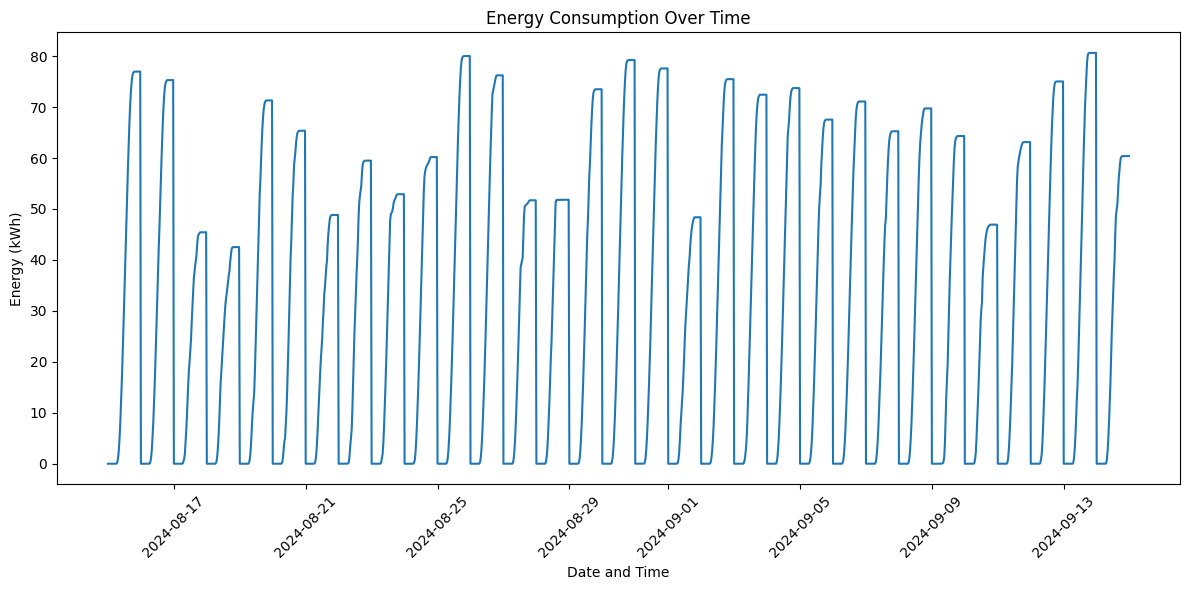

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Split the data into training and testing sets (80% train, 20% test)

In [ ]:
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
def make_stationary(data):
    diff_cols = []
    stationary_data = data.copy()

    for column in data.columns:
        # Perform ADF test
        result = adfuller(data[column])
        print(f"\nTesting {column}:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        print(f"Critical values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value:.4f}")

        # If p-value > 0.05, difference the series
        if result[1] > 0.05:
            print(f">>> {column} is NOT stationary (p-value > 0.05)")
            print(f">>> Applying differencing to {column}")
            stationary_data[column] = data[column].diff()
            diff_cols.append(column)

            # Check stationarity after differencing
            result_after = adfuller(stationary_data[column].dropna())
        else:
            print(f">>> {column} is already stationary (p-value <= 0.05)")

    # Print summary of modifications
    print("\n=== Summary of Modifications ===")
    print(f"Number of columns differenced: {len(diff_cols)} out of {len(data.columns)}")

    # Drop NaN values created by differencing
    original_len = len(stationary_data)
    stationary_data = stationary_data.dropna()
    new_len = len(stationary_data)
    print(f"\nRows dropped due to NaN values: {original_len - new_len}")

    return stationary_data, diff_cols

# Apply to both train and test
print("\nProcessing Training Data:")
stationary_train, diffed_cols = make_stationary(train_data)

stationary_test = test_data.copy()
for col in diffed_cols:
    print(f"Differencing column: {col}")
    stationary_test[col] = test_data[col].diff()

original_test_len = len(stationary_test)
stationary_test = stationary_test.dropna()
new_test_len = len(stationary_test)


Processing Training Data:

Testing Energy:
ADF Statistic: -13.5438
p-value: 0.0000
Critical values:
	1%: -3.4360
	5%: -2.8640
	10%: -2.5681
>>> Energy is already stationary (p-value <= 0.05)

Testing Efficiency:
ADF Statistic: -13.5435
p-value: 0.0000
Critical values:
	1%: -3.4360
	5%: -2.8640
	10%: -2.5681
>>> Efficiency is already stationary (p-value <= 0.05)

Testing Power:
ADF Statistic: -12.2004
p-value: 0.0000
Critical values:
	1%: -3.4360
	5%: -2.8640
	10%: -2.5681
>>> Power is already stationary (p-value <= 0.05)

Testing Average:
ADF Statistic: -12.5386
p-value: 0.0000
Critical values:
	1%: -3.4360
	5%: -2.8640
	10%: -2.5681
>>> Average is already stationary (p-value <= 0.05)

Testing Normalised:
ADF Statistic: -12.5363
p-value: 0.0000
Critical values:
	1%: -3.4360
	5%: -2.8640
	10%: -2.5681
>>> Normalised is already stationary (p-value <= 0.05)

Testing Temperature:
ADF Statistic: -9.9885
p-value: 0.0000
Critical values:
	1%: -3.4359
	5%: -2.8640
	10%: -2.5681
>>> Temperatur

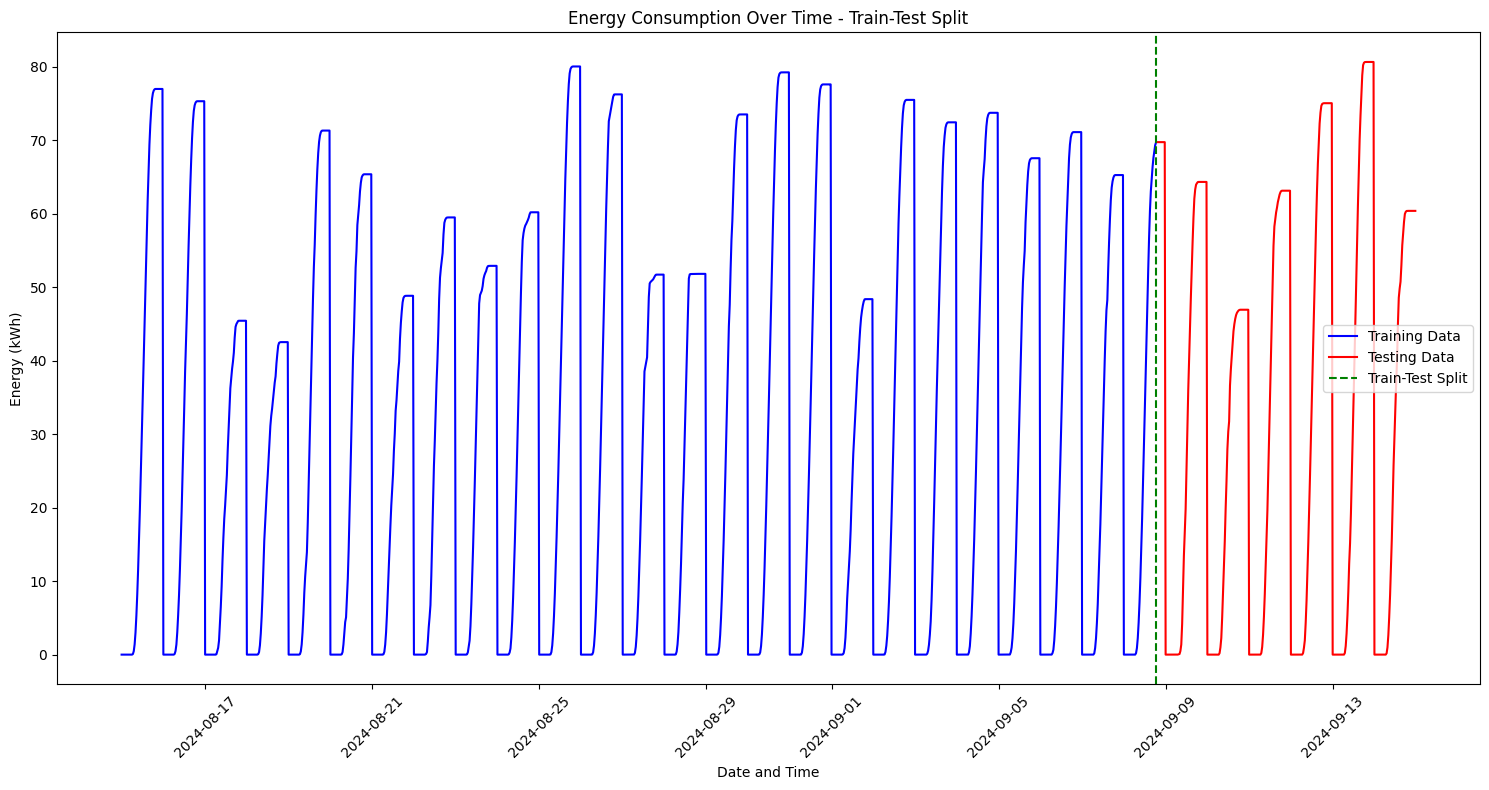

In [ ]:
plt.figure(figsize=(15, 8))

# Plot training data
plt.plot(train_data.index, train_data['Energy'], label='Training Data', color='blue')

# Plot testing data
plt.plot(test_data.index, test_data['Energy'], label='Testing Data', color='red')


# Add a vertical line to show the split point
split_date = train_data.index[-1]
plt.axvline(x=split_date, color='green', linestyle='--', label='Train-Test Split')

plt.title('Energy Consumption Over Time - Train-Test Split')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
scaler = StandardScaler()

# Create new scaled DataFrame
scaled_train = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)

scaled_test = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

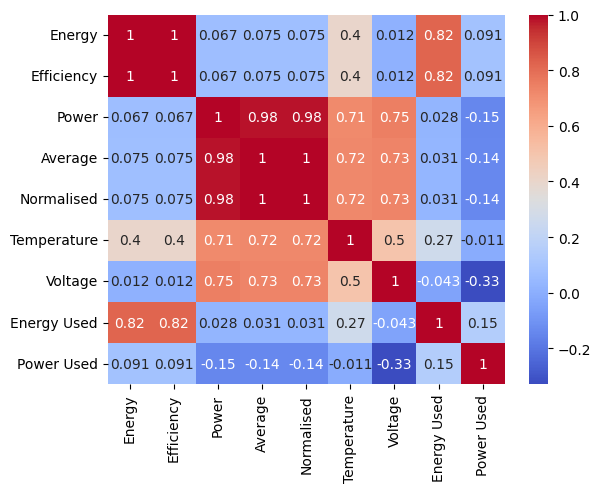

In [ ]:
sns.heatmap(scaled_train.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
scaled_train.drop(columns=['Efficiency', 'Average', 'Normalised'], inplace=True)
scaled_test.drop(columns=['Efficiency', 'Average', 'Normalised'], inplace=True)

Since Power, Avarage and Normalsied are very similar correlated varaibles I will only keep Power. Similary Energy Used and Energy are highly correlated, hence I will exclude Energy used. Efficiency and Enegy have also a strong correlation.  

In [ ]:
model = VAR(scaled_train)
lag_order = model.select_order(maxlags=25)
aic_lag = lag_order.selected_orders['aic']
bic_lag = lag_order.selected_orders['bic']
hqic_lag = lag_order.selected_orders['hqic']
print(f"AIC: {aic_lag}, BIC: {bic_lag}, HQIC: {hqic_lag}")
print(lag_order.summary())
optimal_lag = lag_order.selected_orders['aic']
print(f"Optimal lag: {optimal_lag}")

AIC: 19, BIC: 1, HQIC: 2
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.123      -3.097     0.04401      -3.113
1       -12.20     -12.02*   5.041e-06      -12.13
2       -12.32      -11.98   4.483e-06     -12.19*
3       -12.36      -11.86   4.288e-06      -12.17
4       -12.40      -11.74   4.138e-06      -12.15
5       -12.44      -11.63   3.970e-06      -12.13
6       -12.45      -11.48   3.923e-06      -12.09
7       -12.44      -11.32   3.947e-06      -12.02
8       -12.42      -11.14   4.033e-06      -11.94
9       -12.42      -10.98   4.054e-06      -11.88
10      -12.41      -10.82   4.094e-06      -11.81
11      -12.40      -10.66   4.116e-06      -11.74
12      -12.40      -10.50   4.122e-06      -11.68
13      -12.47      -10.41   3.851e-06      -11.69
14      -12.50      -10.29   3.715e-06      -11.67
15      -12.53      -10.16  3.630e-06*      -11.63
16    

In [ ]:
model_fitted = model.fit(optimal_lag)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, Nov, 2024
Time:                     12:19:12
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -9.51585
Nobs:                     1171.00    HQIC:                  -11.3750
Log likelihood:          -1960.29    FPE:                3.73820e-06
AIC:                     -12.5007    Det(Omega_mle):     2.13088e-06
--------------------------------------------------------------------
Results for equation Energy
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.010463         0.007809            1.340           0.180
L1.Energy               0.597578         0.058379           10.236           0.000
L1.Power                0.046776         0.026097  

In [ ]:
forecast_steps = len(scaled_test)
forecast = model_fitted.forecast(scaled_train.values[-optimal_lag: ], steps=forecast_steps)

# Convert predictions to DataFrame
forecast_df = pd.DataFrame(forecast, index=scaled_test.index, columns=scaled_train.columns)

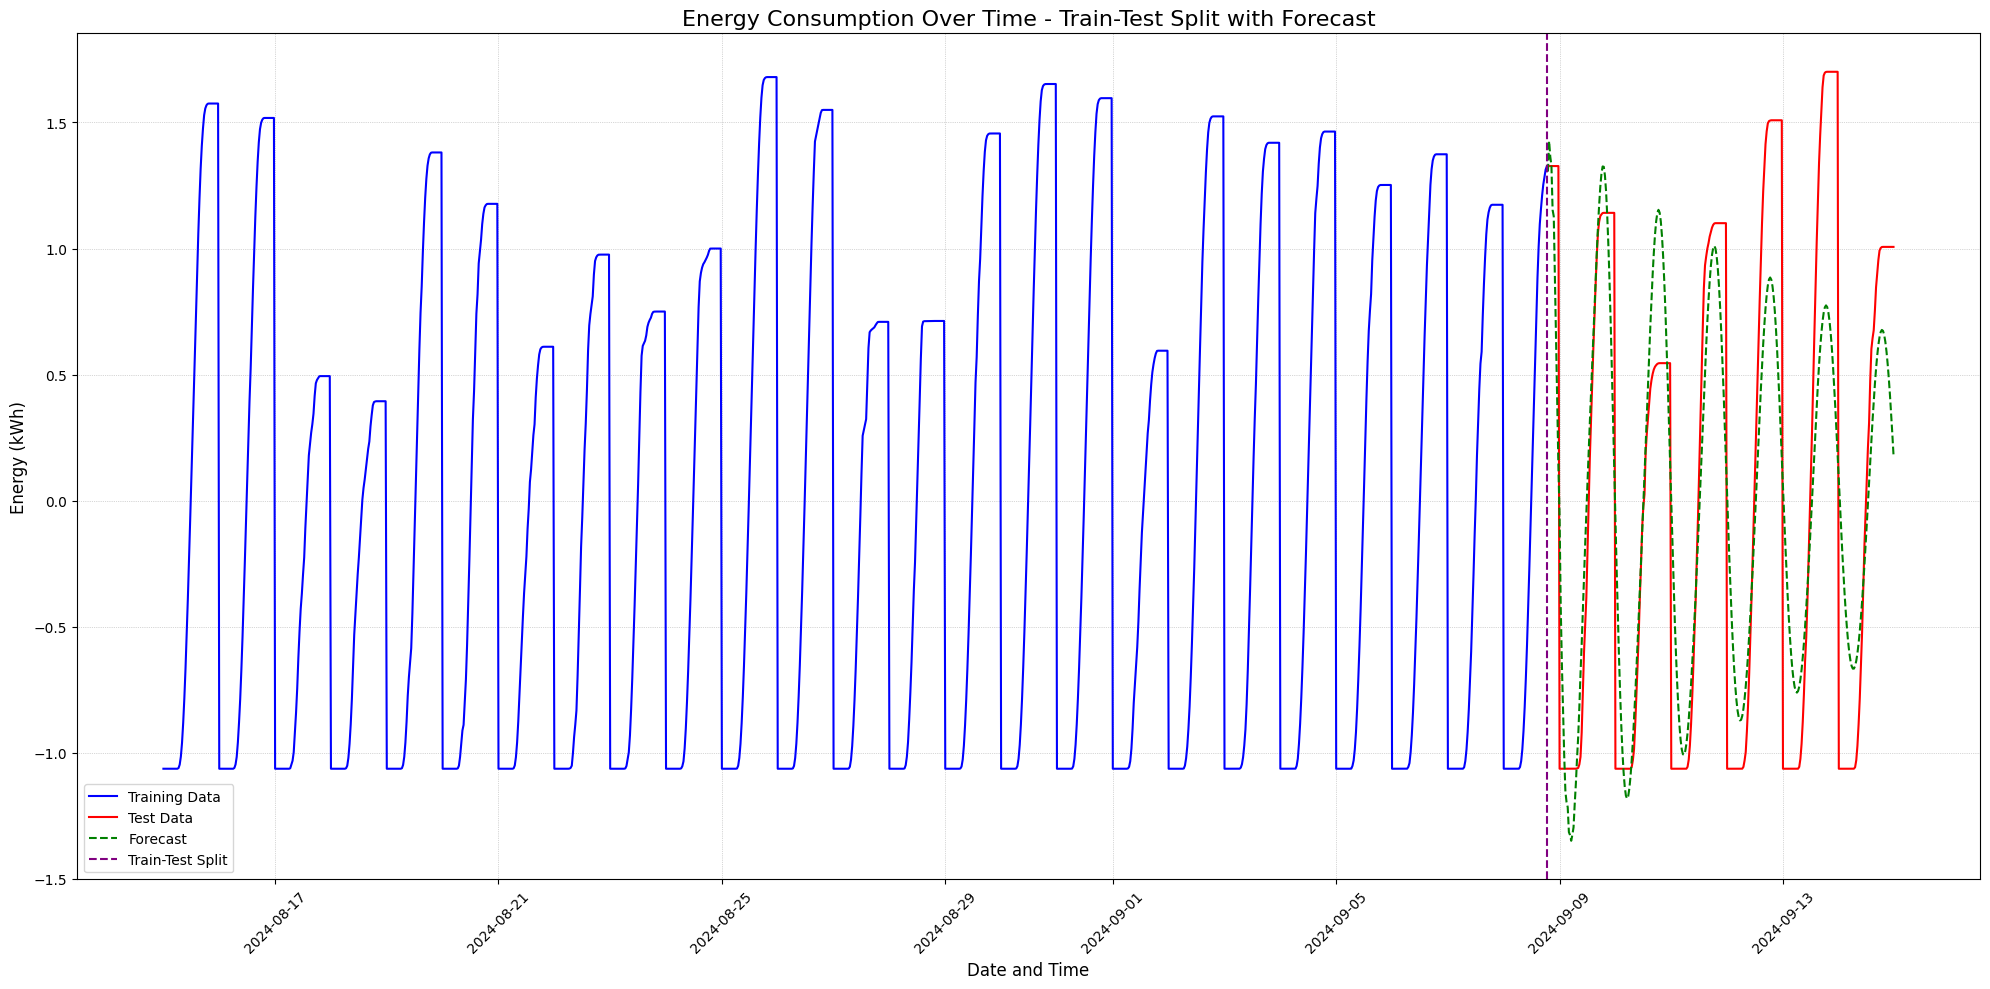

In [ ]:
plt.figure(figsize=(20, 10))

# Plot training data
plt.plot(scaled_train.index, scaled_train['Energy'], label='Training Data', color='blue')

# Plot testing data
plt.plot(scaled_test.index, scaled_test['Energy'], label='Test Data', color='red')

# Plot forecast
plt.plot(scaled_test.index, forecast_df['Energy'], label='Forecast', color='green', linestyle='--')

# split point
split_date = scaled_train.index[-1]
plt.axvline(x=split_date, color='purple', linestyle='--', label='Train-Test Split')

plt.title('Energy Consumption Over Time - Train-Test Split with Forecast', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()

plt.show()

In [ ]:
def evaluate_var_model(model_fitted, scaled_train, scaled_test, forecast_df):

  # 1 Check R-squared values
  print("\nR-sqaured values:")
  for i, col in enumerate(scaled_train.columns):
    print(f"{col}: {model_fitted.fittedvalues[col].corr(scaled_train[col]):.4f}")

  # 2 Calculate the error metrics for each varaible
  print("\nError metrics:")
  for column in scaled_test.columns:
    mae = mean_absolute_error(scaled_test[column], forecast_df[column])
    rmse = np.sqrt(mean_squared_error(scaled_test[column], forecast_df[column]))
    print(f'{column} - MAE: {mae}, RMSE: {rmse}')


evaluate_var_model(model_fitted, scaled_train, scaled_test, forecast_df)



R-sqaured values:
Energy: 0.9675
Power: 0.9441
Temperature: 0.9819
Voltage: 0.7916
Energy Used: 0.9335
Power Used: 0.7404

Error metrics:
Energy - MAE: 0.3970154981841766, RMSE: 0.5135839933592513
Power - MAE: 0.4744410214734343, RMSE: 0.6322340530723084
Temperature - MAE: 1.2491458883907933, RMSE: 1.393838790921487
Voltage - MAE: 0.5708236979639227, RMSE: 0.7105069985452916
Energy Used - MAE: 0.5031514398966004, RMSE: 0.6667648781608648
Power Used - MAE: 0.8363335757830884, RMSE: 1.0159805065801453


In [ ]:
mae_values = [0.3970, 0.4744, 1.2491, 0.5708, 0.5032, 0.8363]
rmse_values = [0.5136, 0.6322, 1.3938, 0.7105, 0.6668, 1.0160]

# Calculate average MAE and RMSE
overall_mae = sum(mae_values) / len(mae_values)
overall_rmse = sum(rmse_values) / len(rmse_values)

print(f"Overall MAE: {overall_mae:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")


Overall MAE: 0.6718
Overall RMSE: 0.8222
